In [219]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize as opt
import sys

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def flat_for(a, f):
    a = a.reshape(-1)
    for i, v in enumerate(a):
        a[i] = f(v)

def sample(n):
    source_xs = [[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    source_ys = [[1.0], [1.0], [0.0], [0.0]]
    source_inds = [random.randint(0,len(source_xs) - 1) for i in xrange(n)]
    xs = np.matrix([source_xs[i] for i in source_inds]) + np.random.randn(n,2) * 0.25
    ys = np.matrix([source_ys[i] for i in source_inds])
    return {'xs': xs, 'ys': ys}

In [220]:
sample(3)['ys']

matrix([[ 0.],
        [ 0.],
        [ 0.]])

In [221]:
class NeuralNetwork:
    """
    basic neural network with training via backpropagation
        follows notation from Andrew Ng's Machine Learning Coursera Course (week 5)
    """
    
    def __init__(self, layer_sizes, thetas=None):
        self.layer_sizes = layer_sizes
        self.epsilon = 0.25
        np.random.seed(1)
        # one row is added for bias term
        transitions = [layer_sizes[i:i+2] for i in range(0, len(layer_sizes)-1)]
        self.layer_dim_edges = [(t[1],t[0]+1) for t in transitions]
        self.thetas      = thetas if thetas else [np.matrix(np.random.rand(t[0], t[1])) * 2 * self.epsilon - self.epsilon for t in self.layer_dim_edges]
        self.train_j = []
        self.train_gtol = []
        self.lambda_val  = 0.001
        self.num_layers = len(self.thetas)

    def unflatten_thetas(self, flat):
        current = 0
        unflattened = []
        for dims in self.layer_dim_edges:
            count = dims[0] * dims[1]
            unflattened += [np.matrix(np.reshape(flat[current:current+count], dims))]
            current += count
        return unflattened
    
    def flatten(self, ary):
        return np.hstack([np.asarray(ele.flatten()) for ele in ary])[0]
    
    def cost(self, xs, ys):
        m = float(xs.shape[0])
        j = self.lambda_val / (2.0 * m) * np.sum(np.power(self.flatten(self.thetas), 2.0))
        for i in range(xs.shape[0]):
            h_theta = self.forward_propagate(xs[i].T)[-1]
            j += -1.0 / m * (ys[i].dot(np.log(h_theta)) + (1.0 - ys[i]).dot(np.log(1.0 - h_theta)))[0,0]
        return j
    
    def create_f(self, xs, ys, new_thetas):
        nn = NeuralNetwork(self.layer_sizes, self.unflatten_thetas(new_thetas))
        j = nn.cost(xs, ys)
        tup = nn.compute_gradient(xs, ys)
        d = self.flatten(tup[0])
        gtol = tup[1]
        self.train_j.append(j)
        self.train_gtol.append(gtol)
        return (j, d)
        
    def train(self, xs, ys):
        f = lambda new_thetas: self.create_f(xs, ys, new_thetas)
        xopt = opt.fmin_l_bfgs_b(f, self.flatten(self.thetas), pgtol=1e-10) #gtol=1e-10, epsilon=1.0, 
        self.thetas = self.unflatten_thetas(xopt[0])
        return xopt
            
    def forward_propagate(self, x):
        state = x
        activations = [self.add_bias_w(x)]
        for theta in self.thetas[:-1]:
            state = self.layer_step(theta, activations[-1])
            flat_for(state, sigmoid)
            activations.append(self.add_bias_w(state))
        last_step = self.layer_step(self.thetas[-1], activations[-1])
        flat_for(last_step, sigmoid)
        activations.append(last_step)
        return activations
    
    def back_propagate(self, x, y):
        activations = self.forward_propagate(x)
        deltas = [None] * (self.num_layers+1)
        grad = [None] * self.num_layers
        deltas[-1] = activations[-1] - y
        for l in range(self.num_layers-1, 0, -1):
            deltas[l] = np.multiply(self.thetas[l].T.dot(deltas[l+1]),
                                    np.multiply(activations[l], 1.0 - activations[l]))
        for l in range(0, self.num_layers):
            # remove the change in bias term activation when propagating to earlier layers
            delta_sel = deltas[l+1] if l == self.num_layers-1 else deltas[l+1][1:,:]
            grad[l] = delta_sel.dot(activations[l].T)
        return grad
    
    def compute_gradient(self, xs, ys):
        assert(xs.shape[0] == ys.shape[0])
        m = float(len(xs))
        D = self.back_propagate(xs[0].T, ys[0].T)
        for x, y in zip(xs[1:], ys[1:]):
            xyD = self.back_propagate(x.T, y.T)
            for l in range(0, self.num_layers):
                D[l] += xyD[l]
        for l in range(0, self.num_layers):
            D[l] /= m
        D[l][:,1:] += self.lambda_val * self.thetas[l][:,1:]
        flat = self.flatten(D)
        gtol = np.linalg.norm(flat,2.0)
        #sys.stdout.write('.') #(i+1) / float(itr),
        #sys.stdout.flush()
        return D, gtol
    
    def update(self, D):
        for i in range(0,len(self.thetas)):
            self.thetas[i] -= D[i]
    
    def add_bias_w(self, v):
        return np.vstack([np.matrix([[1]]), v])
    
    # theta(nodes_ldim x input_dim) * x_or_z(input_dim x 1)
    def layer_step(self, theta, x_or_z):
        return theta.dot(x_or_z)
    
    def print_thetas(self):
        print "\n\nthetas:"
        for theta in self.thetas:
            print theta
            print

In [222]:
# train with bfgs

layer_sizes = [2, 2, 1]
nn2 = NeuralNetwork(layer_sizes)

np.random.seed(0)
samples = sample(1000)

xopt = nn2.train(samples['xs'], samples['ys'])
nn2.print_thetas()
nn2.cost(samples['xs'],samples['ys'])



thetas:
[[ 2.91458284 -0.28239879 -5.3279333 ]
 [ 2.43171985  0.00976544 -4.47129043]]

[[-6.62630716  7.26920191  5.6173696 ]]



0.05349295348581818

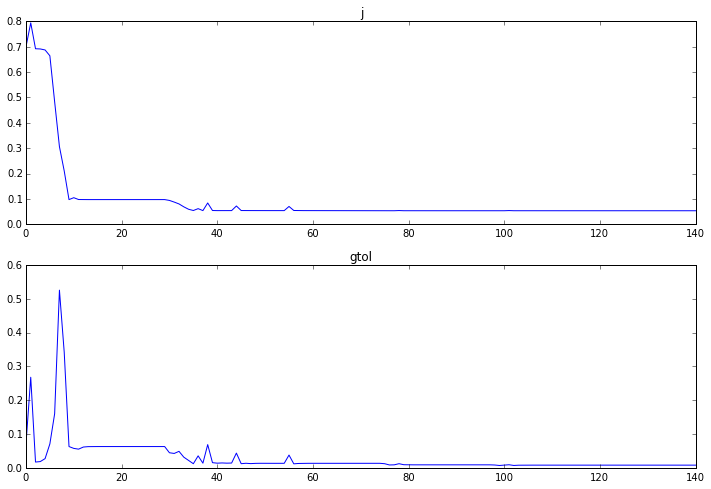

In [223]:
plt.figure(figsize=[12,8])
plt.subplot(2,1,1)
plt.plot(nn2.train_j)
plt.title('j')
plt.subplot(2,1,2)
plt.plot(nn2.train_gtol)
plt.title('gtol')

In [237]:
# train by simply updating with -gradient

layer_sizes = [2, 2, 1]
nn = NeuralNetwork(layer_sizes)
gtols = []
js = []

np.random.seed(0)
itr = 10000
print '_'*50
for i in xrange(itr):
    if (i+1) % (itr / 50) == 0:
        sys.stdout.write('|') #(i+1) / float(itr),
        sys.stdout.flush()
    samples = sample(4)
    xs = samples['xs']
    ys = samples['ys']
    tup = nn.compute_gradient(xs, ys)
    D = tup[0]
    gtol = tup[1]
    gtols.append(gtol)
    js.append(nn.cost(xs, ys))
    nn.update(D)

nn.print_thetas()
nn.cost(xs, ys)

__________________________________________________
||||||||||||||||||||||||||||||||||||||||||||||||||

thetas:
[[  5.96784286  -0.56728281 -10.48785248]
 [  4.41542877   0.22568513 -10.36688758]]

[[-4.1708831   4.54889133  4.42830184]]



0.057920488566910809

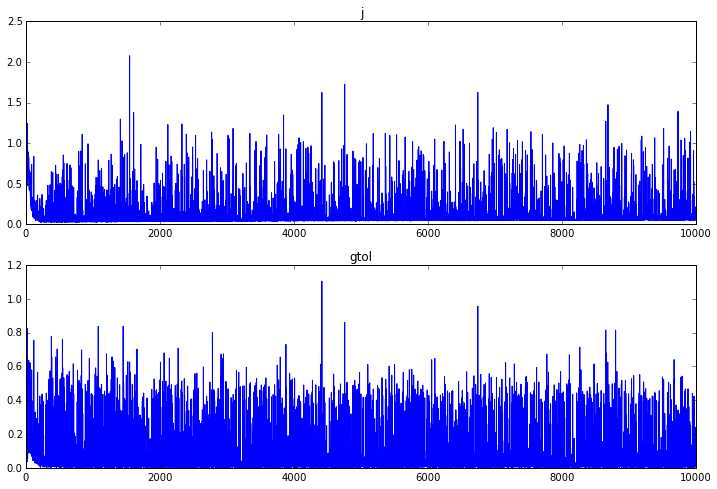

In [238]:
plt.figure(figsize=[12,8])
plt.subplot(2,1,1)
plt.plot(js)
plt.title('j')
plt.subplot(2,1,2)
plt.plot(gtols)
plt.title('gtol')

In [241]:
tests = [[0.0,1.0],[1.0,0.0],[0.0,0.0],[1.0,1.0]]
print tests

[nn.forward_propagate(np.matrix([t]).T)[-1] for t in tests]

[[0.0, 1.0], [1.0, 0.0], [0.0, 0.0], [1.0, 1.0]]


[matrix([[ 0.01613669]]),
 matrix([[ 0.99136755]]),
 matrix([[ 0.9913525]]),
 matrix([[ 0.01585054]])]

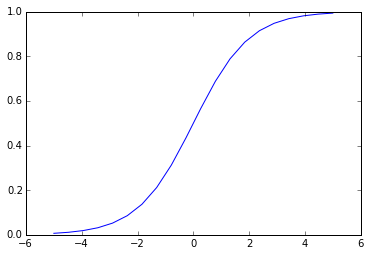

In [205]:
xs = np.linspace(-5, 5, 20)
plt.plot(xs, sigmoid(xs))